In [1]:
## Passing Y as input while conda asks for confirmation, we use yes command
!yes Y | conda install faiss-gpu cudatoolkit=10.0 -c pytorch

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

yes: standard output: Broken pipe


In [2]:
# !wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
# !tar xvjf tsnecuda-2.1.0-cuda100.tar.bz2
# !cp -r site-packages/* /opt/conda/lib/python3.6/site-packages/
# # !export LD_LIBRARY_PATH="/kaggle/working/lib/" 
# !cp /kaggle/working/lib/libfaiss.so /usr/local/cuda/lib64/

In [3]:
!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda100.tar.bz2 --wildcards 'lib/*'
!tar xvjf tsnecuda-2.1.0-cuda100.tar.bz2 --wildcards 'site-packages/*'
!cp -r site-packages/* /opt/conda/lib/python3.6/site-packages/
# !export LD_LIBRARY_PATH="/kaggle/working/lib/" 
!cp /kaggle/working/lib/libfaiss.so /usr/local/cuda/lib64/

--2022-11-05 03:00:03--  https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.92.24, 104.17.93.24, 2606:4700::6811:5c18, ...
Connecting to anaconda.org (anaconda.org)|104.17.92.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5d019c23c7424a015486440c/5d790a95778a870c42137059?response-content-disposition=attachment%3B%20filename%3D%22tsnecuda-2.1.0-cuda100.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27tsnecuda-2.1.0-cuda100.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=600&X-Amz-Date=20221105T030003Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEPf%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJGMEQCIDOU3ODPvqgzJbjlitm9%2FWA7ZeqhN28qkFVXYwfU72nRAiAn4pXO8PEniueuNrCSjXiDA9eApR2a7OwVmKgjgBCOaSrVBAjf%2F%2F%2F%2F%2F%2F%2F%2F%2F%2F8BEAAaDDQ1NTg2NDA5ODM3OCIMF%2F

In [4]:
!apt search openblas
!yes Y | apt install libopenblas-dev 
# !printf '%s\n' 0 | update-alternatives --config libblas.so.3 << 0
# !apt-get install libopenblas-dev 
!

Sorting... Done
Full Text Search... Done
libopenblas-base/oldstable,now 0.2.19-3 amd64 [installed,automatic]
  Optimized BLAS (linear algebra) library (shared library)

libopenblas-dev/oldstable,now 0.2.19-3 amd64 [installed]
  Optimized BLAS (linear algebra) library (development files)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopenblas-dev is already the newest version (0.2.19-3).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
yes: standard output: Broken pipe


In [10]:
import faiss
from tsnecuda import TSNE
import pandas as pd
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [31]:
image_list = [np.sum(cv2.resize(cv2.imread("../input/ocrdataset/data_2021/bdh/"+x, 0), (300, 100)), axis=0) for x in sorted(os.listdir("../input/ocrdataset/data_2021/bdh/"))]
x = np.array(image_list)
y = np.array(pd.read_excel('../input/ocrdataset/data_2021/code_bdh.xlsx', header=None))
#plt.imshow(image_list[666])

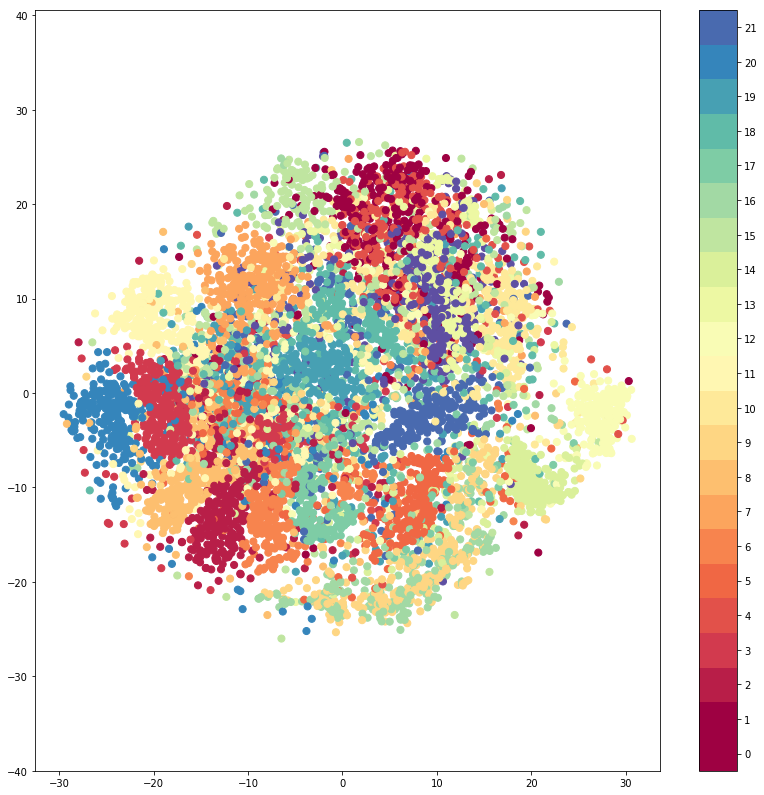

In [32]:
tsne = TSNE(n_components=2,verbose=5, perplexity=40, n_iter=10000, learning_rate=200).fit_transform(x)
df = pd.DataFrame()
df['x'] = tsne[:, 0]
df['y'] = tsne[:, 1]
df['c'] = y

plt.figure(figsize=(14, 14))
plt.scatter(df['x'], df['y'], c=df['c'],s=50, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(23)-0.5).set_ticks(np.arange(22))

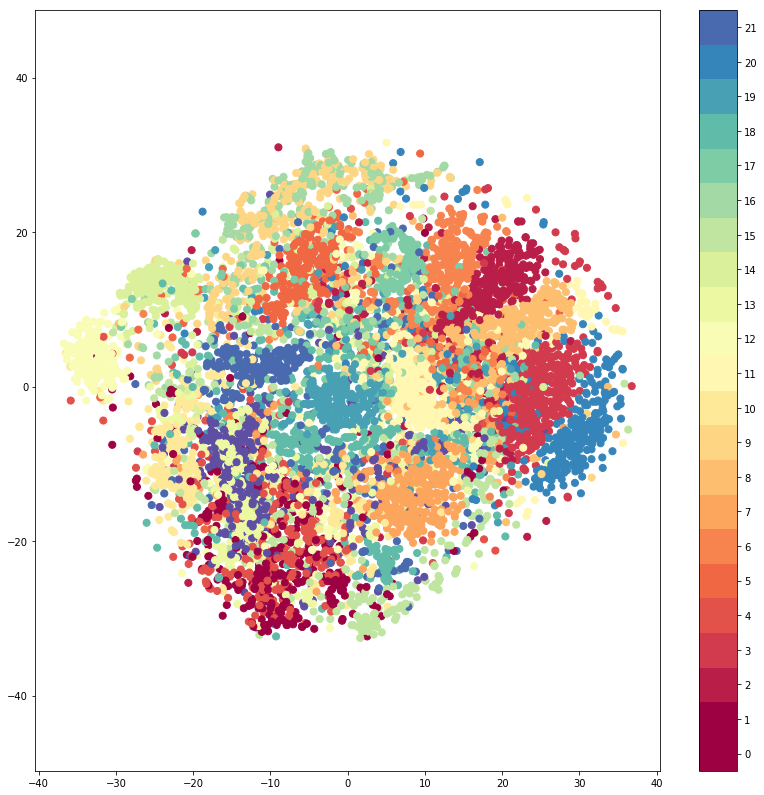

In [33]:
pca_250 = PCA(n_components=250)
pca_result_250 = pca_250.fit_transform(x)
tsne = TSNE(n_components=2,verbose=5, perplexity=30, n_iter=10000, learning_rate=200).fit_transform(pca_result_250)
df = pd.DataFrame()
df['x'] = tsne[:, 0]
df['y'] = tsne[:, 1]
df['c'] = y

plt.figure(figsize=(14, 14))
plt.scatter(df['x'], df['y'], c=df['c'],s=50, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(23)-0.5).set_ticks(np.arange(22))

# raw data

In [34]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019,
    tree_method='gpu_hist'  
)
clf.fit(X_train, y_train)

ypred = clf.predict(X_test)
confusion = confusion_matrix(y_test, ypred)
print('Confusion Matrix\n')
print(confusion)
print(classification_report(y_test, ypred, digits=4))

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix

[[39  0  0 11  0  0  0  1  1  0  0  1  0  0  1  0  0  0  1  0  0  1]
 [ 0 48  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0 46  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0]
 [ 6  0  0 32  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0 49  0  0  0  0  0  0  0  0  2  0  0  1  1  0  0  0  1]
 [ 0  0  1  0  2 38  3  0  0  0  0  0  0  0  0  0  0  0  1  4  0  0]
 [ 0  0  0  0  0  0 55  1  0  0  0  0  0  0  0  0  1  0  1  0  0  1]
 [ 0  1  2  0  0  1  0 41  1  0  0  0  0  0  0  1  1  1  0  0  0  0]
 [ 0  0  0  0  1  0  0  1 51  1  0  0  1  0  0  8  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 35  0  3  2  0  1  0  0  0  0  0  0  2]
 [ 0  0  1  0  0  0  0  0  0  0 60  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  0  0  0  0  1  0 44  0  1  0  0  0  0  0  0  0  1]
 [ 2  0  0  0  0  0  0  0  0  3  0  0 40  0  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  5  0  1  1 39  0  0  0  0  0  0  0  0]
 [ 2  0  1  0  0

In [11]:
confusion = confusion_matrix(y_test, ypred)
print('Confusion Matrix\n')
print(confusion)
print(classification_report(y_test, ypred, digits=4))

Confusion Matrix

[[43  1  1  3  0  0  0  0  0  2  0  1  0  0  3  0  0  2  0  0  0  0]
 [ 0 48  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0 46  0  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0 35  0  0  0  0  0  0  0  1  0  0  2  0  1  0  0  0  0  0]
 [ 0  1  0  0 48  0  0  0  0  0  0  0  0  0  0  2  0  0  1  0  1  1]
 [ 0  3  1  0  0 38  0  0  0  0  1  0  0  0  0  0  2  1  1  1  1  0]
 [ 0  0  0  0  4  0 49  0  1  0  0  0  0  0  0  4  0  0  0  0  0  1]
 [ 0  0  2  0  0  1  0 41  2  0  1  0  0  0  0  0  0  1  0  1  0  0]
 [ 0  0  0  0  0  0  4  1 42  0  0  1  0  1  0 13  0  0  0  2  1  0]
 [ 1  0  1  0  0  0  0  0  0 34  0  0  5  0  0  1  0  0  0  0  0  1]
 [ 0  1  0  0  0  0  0  0  0  0 58  0  0  0  0  0  0  1  0  2  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0 44  0  0  0  0  1  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  2  0  0  0 45  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0  0 40  0  2  1  1  0  0  0  0]
 [ 5  1  0  2  0

In [12]:
X_train, X_test, y_train, y_test = train_test_split(tsne, y, test_size=0.15, random_state=42)
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019,
    tree_method='gpu_hist'  
)
clf.fit(X_train, y_train)

ypred = clf.predict(X_test)
confusion = confusion_matrix(y_test, ypred)
print('Confusion Matrix\n')
print(confusion)
print(classification_report(y_test, ypred, digits=4))

Confusion Matrix

[[18  0  1 21  1  1  0  0  0  1  0  0  0  0  8  0  2  1  0  0  1  1]
 [ 0 45  0  0  0  1  0  0  0  0  1  0  0  0  0  1  0  2  0  0  0  0]
 [ 0  0 39  0  1  1  0  0  0  1  3  0  0  0  0  0  0  1  1  1  0  0]
 [15  0  0 20  0  0  0  0  0  0  0  1  0  0  2  0  2  0  0  0  1  0]
 [ 0  0  0  0 48  0  0  0  0  0  0  1  0  0  2  0  1  1  0  0  0  1]
 [ 0  1  3  0  1 34  0  0  1  0  5  0  0  0  0  0  0  0  0  3  0  1]
 [ 0  0  1  0  0  0 57  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  2  0  0  0  0  0 39  0  2  0  0  1  0  0  2  0  1  0  2  0  0]
 [ 1  0  0  0  0  0  0  3 32  0  0  0  4  0  0 22  1  1  0  0  0  1]
 [ 0  0  1  0  0  0  0  0  0 35  1  1  2  0  1  0  0  1  0  0  0  1]
 [ 0  1  2  0  0  6  0  2  0  0 42  0  0  1  1  0  0  2  1  1  1  2]
 [ 0  0  0  1  0  0  0  0  0  0  0 45  0  1  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  4  0  0 36  0  0  1  0  0  0  0  1  3]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0 40  1  0  2  0  0  0  2  0]
 [ 1  0  0  4  0

In [13]:
X_train, X_test, y_train, y_test = train_test_split(pca_result_250, y, test_size=0.15, random_state=42)
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019,
    tree_method='gpu_hist'  
)
clf.fit(X_train, y_train)

ypred = clf.predict(X_test)
confusion = confusion_matrix(y_test, ypred)
print('Confusion Matrix\n')
print(confusion)
print(classification_report(y_test, ypred, digits=4))

Confusion Matrix

[[38  0  0  3  0  0  0  0  0  2  1  1  0  1  7  0  0  2  0  0  1  0]
 [ 0 44  2  0  0  1  0  1  1  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0 45  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  2  0  0]
 [ 4  0  0 36  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0 48  0  1  0  0  0  0  0  0  0  0  0  0  0  4  0  0  1]
 [ 0  1  0  0  0 46  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0]
 [ 0  0  0  0  1  0 54  0  2  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 46  0  0  0  0  1  0  0  0  0  0  0  1  0  1]
 [ 0  0  0  0  0  0  0  2 49  1  0  0  0  2  0 10  0  0  0  1  0  0]
 [ 1  0  0  0  0  0  0  0  0 36  0  0  5  0  0  0  0  0  0  0  1  0]
 [ 0  0  1  0  0  0  0  0  0  0 58  0  0  0  0  0  0  0  0  1  2  0]
 [ 2  0  0  1  0  0  0  0  0  0  0 44  0  0  0  0  0  1  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  2  0  0  0 43  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 44  0  0  0  1  0  0  1  0]
 [ 2  0  1  2  0